<a href="https://colab.research.google.com/github/TOHA262000/DeepLearning/blob/main/EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7


In [3]:
data_dir = '/content/drive/MyDrive/Machine Learning /Practice/Du2ndDataset'
ds_name = 'fake_hilsa_detection'


In [4]:
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [5]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)

    return df

df = create_df(filepaths, labels)


In [6]:
df

,filepaths,labels
0,/content/drive/MyDrive/Machine Learning /Pract...,fake_hilsa
1,/content/drive/MyDrive/Machine Learning /Pract...,fake_hilsa
2,/content/drive/MyDrive/Machine Learning /Pract...,fake_hilsa
3,/content/drive/MyDrive/Machine Learning /Pract...,fake_hilsa
4,/content/drive/MyDrive/Machine Learning /Pract...,fake_hilsa
...,...,...
995,/content/drive/MyDrive/Machine Learning /Pract...,real_hilsa
996,/content/drive/MyDrive/Machine Learning /Pract...,real_hilsa
997,/content/drive/MyDrive/Machine Learning /Pract...,real_hilsa
998,/content/drive/MyDrive/Machine Learning /Pract...,real_hilsa


In [7]:
def num_of_examples(df, name='df'):
    print(f"{name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

fake_hilsa_detection dataset has 1000 images.


In [8]:

def num_of_classes(df, name='df'):
    print(f"{name} dataset has {len(df['labels'].unique())} classes.")

num_of_classes(df, ds_name)

fake_hilsa_detection dataset has 2 classes.


In [9]:
def classes_count(df, name='df'):

    print(f"{name} dataset: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"'{name}'class has  {num_class} images. ")
        print('-'*70)

classes_count(df, ds_name)

fake_hilsa_detection dataset: 

'fake_hilsa'class has  500 images. 
----------------------------------------------------------------------
'real_hilsa'class has  500 images. 
----------------------------------------------------------------------


In [10]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage Chart'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

cat_summary_with_graph(df,'labels')

In [11]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"{name} DataFrame has no null values.")

    else:
        print(f"The {name} DataFrame has {num_null_vals} null values.")
        print('-'*70)
        print('Total null values in each column:')
        print(df.isnull().sum())


check_null_values(df, ds_name)

fake_hilsa_detection DataFrame has no null values.


In [12]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [13]:
def num_imgs(df, name='df'):
    print(f"{name} set contains {len(df)} images.")

In [14]:

num_imgs(train_df, 'Training ')
num_imgs(valid_df, 'Validation ')
num_imgs(test_df, 'Testing ')


Training  set contains 700 images.
Validation  set contains 150 images.
Testing  set contains 150 images.


In [15]:

num_of_classes(train_df, "Training ")
num_of_classes(valid_df, "Validation ")
num_of_classes(test_df, "Testing ")

Training  dataset has 2 classes.
Validation  dataset has 2 classes.
Testing  dataset has 2 classes.


In [16]:

classes_count(train_df, 'Training '+ds_name)


Training fake_hilsa_detection dataset: 

'fake_hilsa'class has  351 images. 
----------------------------------------------------------------------
'real_hilsa'class has  349 images. 
----------------------------------------------------------------------


In [17]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col = 'filepaths',
                                       y_col= 'labels',
                                       target_size = img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 700 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


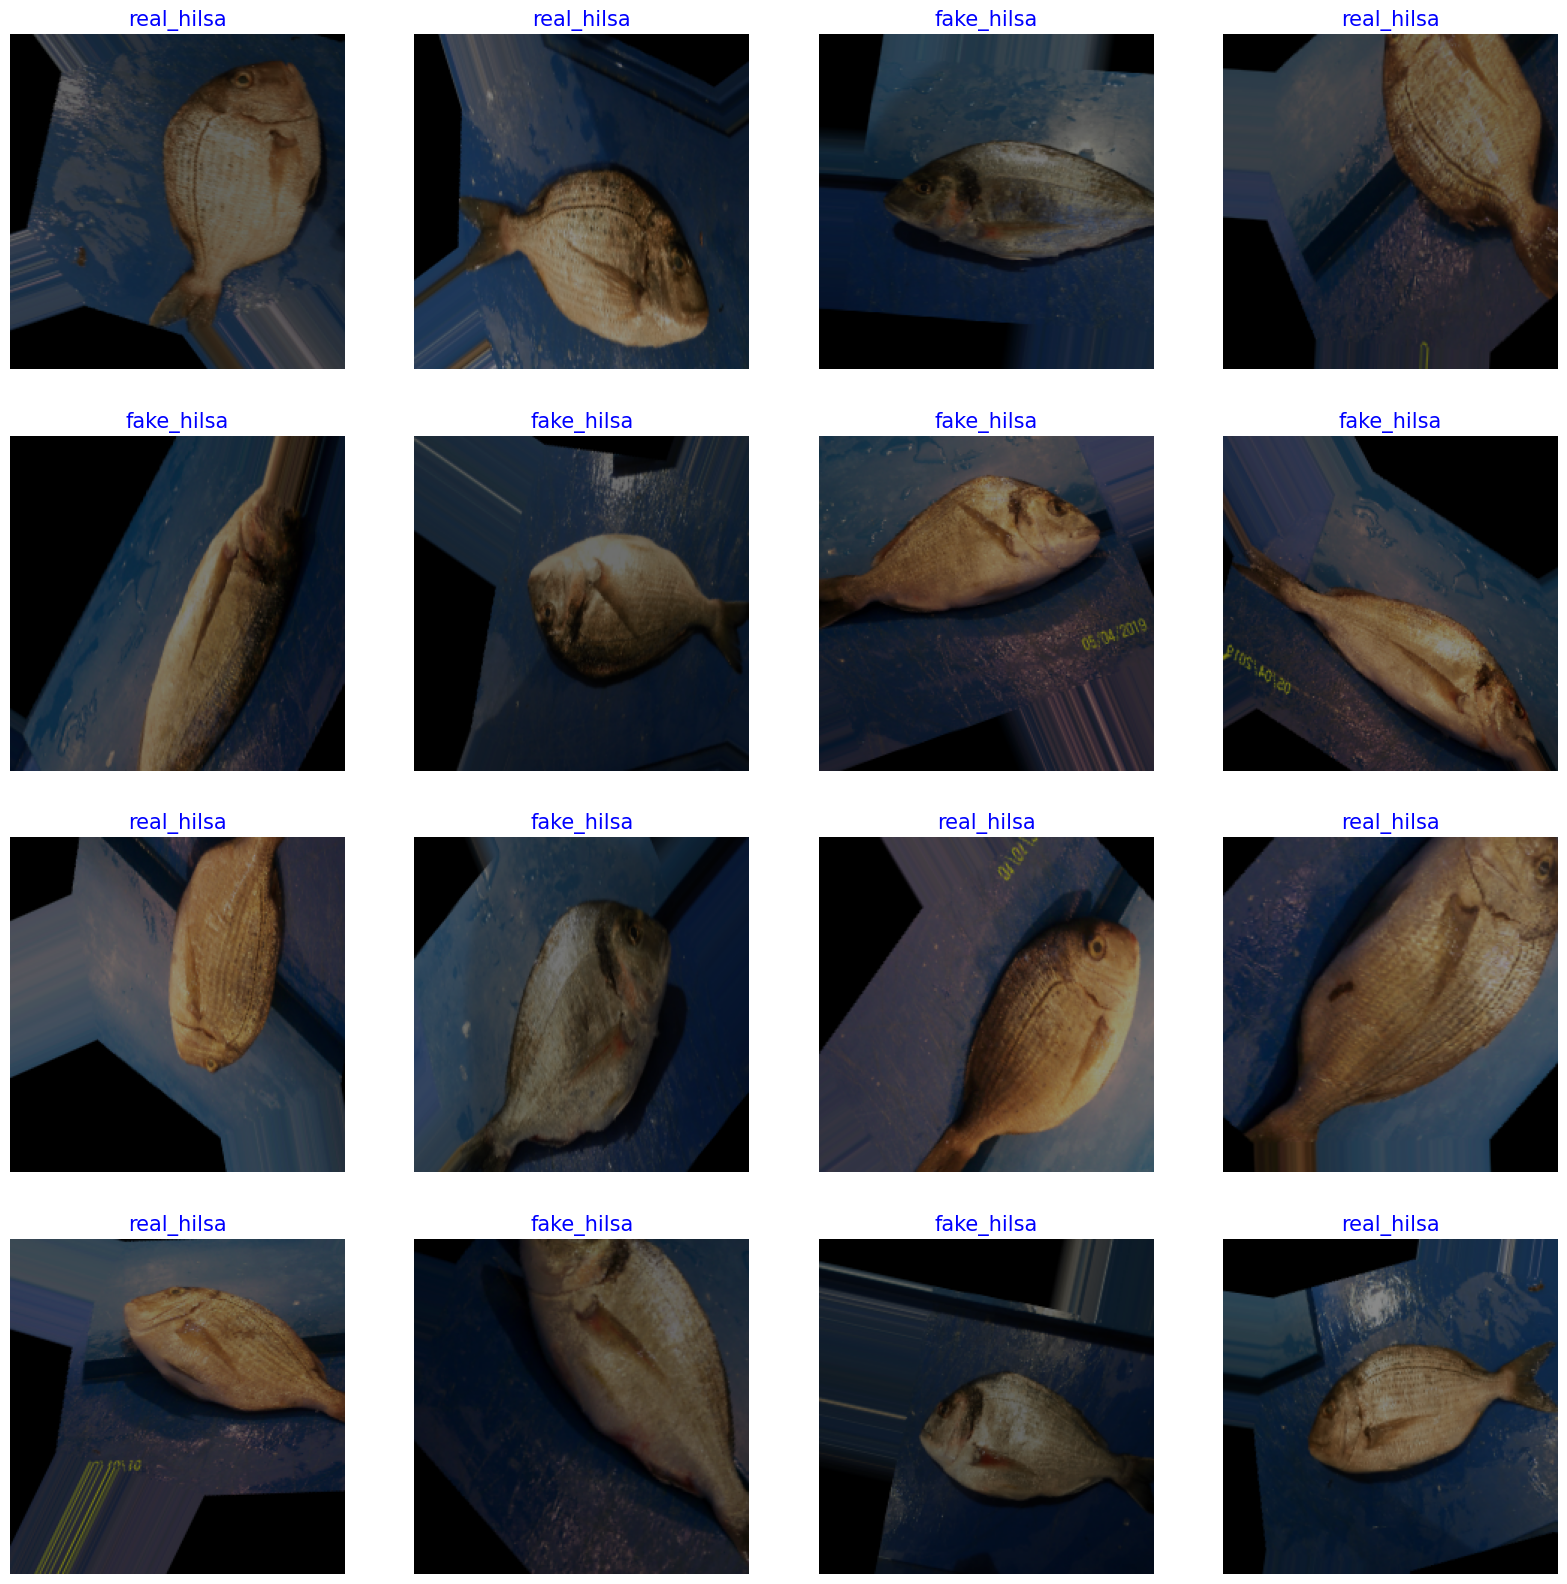

In [18]:
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    index = np.argmax(labels[i])

    class_name = classes[index]

    plt.title(class_name, color='blue', fontsize=15)

    plt.axis('off')

plt.show()

In [19]:
img_size = (224, 224)

channels = 3

img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 64435993 (245.80 MB)
Trainable params: 333

In [20]:

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               mode='min',
                              )

In [21]:

batch_size = 16
epochs = 10

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen,
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

Epoch 1/10
18/18 [==============================] - 545s 28s/step - loss: 4.2025 - accuracy: 0.9286 - val_loss: 4.1134 - val_accuracy: 0.9533
Epoch 2/10
18/18 [==============================] - 475s 27s/step - loss: 3.2251 - accuracy: 0.9671 - val_loss: 3.2546 - val_accuracy: 0.9733
Epoch 3/10
18/18 [==============================] - 448s 25s/step - loss: 2.6691 - accuracy: 0.9671 - val_loss: 2.6298 - val_accuracy: 0.9867
Epoch 4/10
18/18 [==============================] - 455s 25s/step - loss: 2.2429 - accuracy: 0.9843 - val_loss: 2.1445 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 462s 26s/step - loss: 1.9978 - accuracy: 0.9686 - val_loss: 1.9135 - val_accuracy: 0.9800
Epoch 6/10
18/18 [==============================] - 462s 26s/step - loss: 1.7648 - accuracy: 0.9686 - val_loss: 1.6673 - val_accuracy: 0.9867
Epoch 7/10
18/18 [==============================] - 528s 30s/step - loss: 1.5723 - accuracy: 0.9771 - val_loss: 1.4842 - val_accuracy: 0.9867
Epoch 

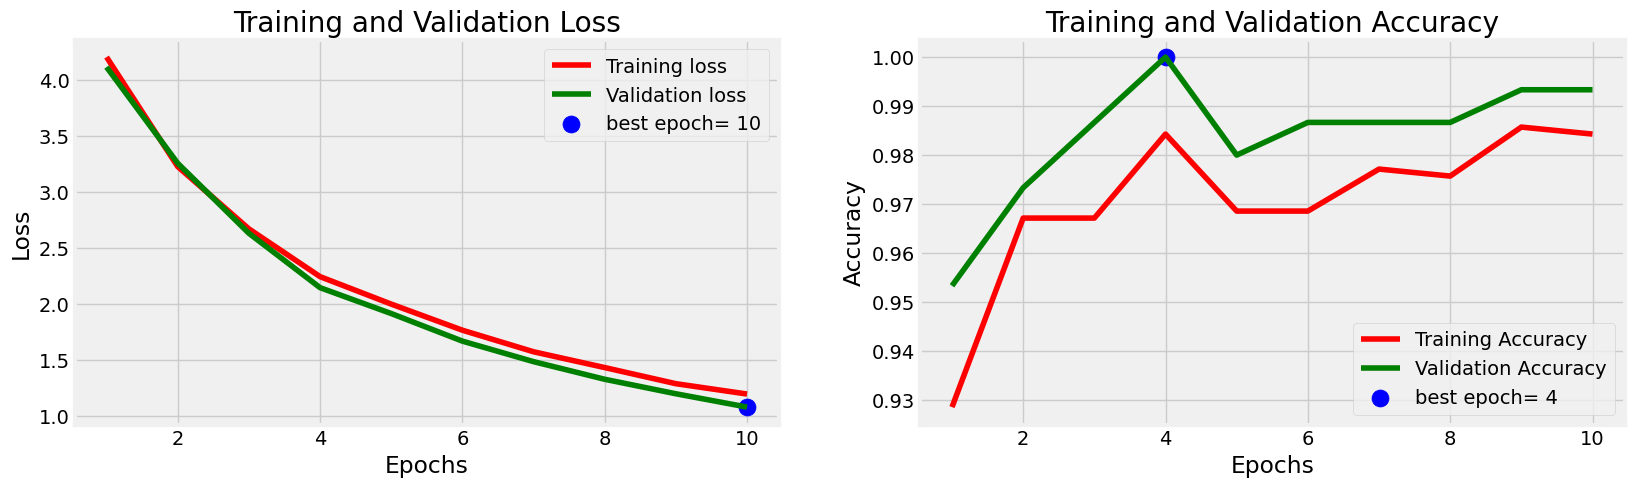

In [22]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [23]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuary: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 97s 50s/step - loss: 1.0677 - accuracy: 1.0000
Train Loss:  1.0660649538040161
Train Accuary:  1.0
--------------------
Validation Loss:  1.0736589431762695
Validation Accuracy:  1.0
--------------------
Test Loss:  1.0677144527435303
Test Accuracy:  1.0


In [24]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

2/2 [==============================] - 99s 42s/step


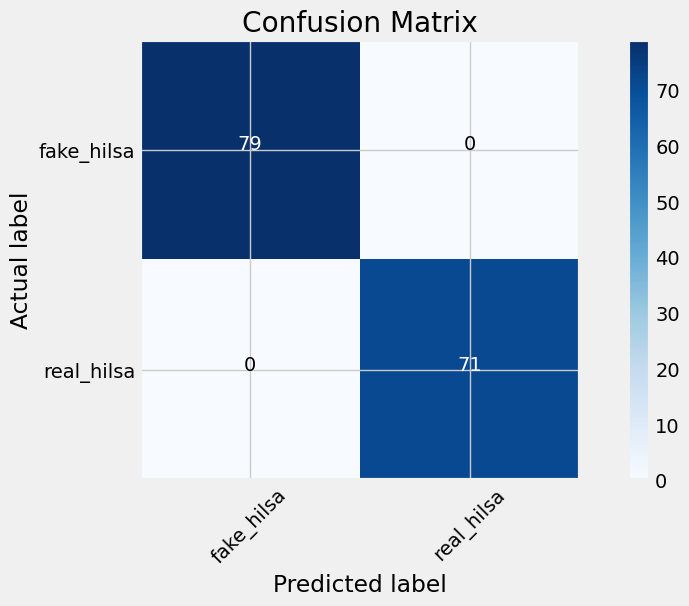

In [25]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()
